In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def add_naive_forecast(df, target_col, months_back, start_date, horizon_months, text):
  
    forecast_col = f"Naive: {months_back}-Month for {text}"
    df[forecast_col] = np.nan

    start = pd.to_datetime(start_date)
    end = start + pd.DateOffset(months=horizon_months - 1)
    reference_date = start - pd.DateOffset(months=months_back)

    if reference_date in df.index:
        naive_value = df[target_col][df.index < start_date].iloc[-1]
        forecast_range = (df.index >= start) & (df.index <= end)
        df.loc[forecast_range, forecast_col] = naive_value

    return df


def getMetrics(df_d, df_r, date1, date2, forecast_type):
    month_name = pd.to_datetime(date1).strftime('%B')
    mask = (df_d.index >= date1) & (df_d.index <= date2)
    y_true = df_d.loc[mask, "Actual Rate"]
    y_pred = df_d.loc[mask, forecast_type]
    forecast_type_split = forecast_type.split(" f")
    if not y_true.isna().all() and not y_pred.isna().all():
        df_r.loc[month_name, f"{forecast_type_split[0]}: MAE"] = mean_absolute_error(y_true, y_pred)
        df_r.loc[month_name, f"{forecast_type_split[0]}: RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return df_r


MAE: 54520.31, RMSE: 62520.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


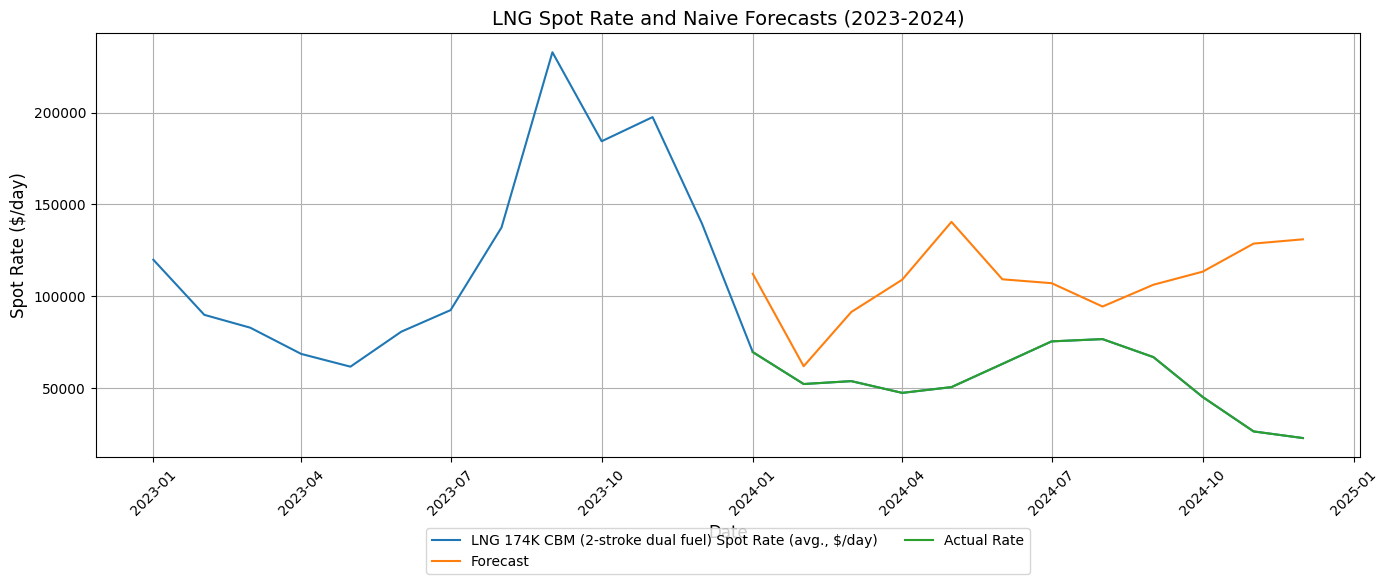

In [3]:
# 12 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 202771.28, RMSE: 234479.49


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


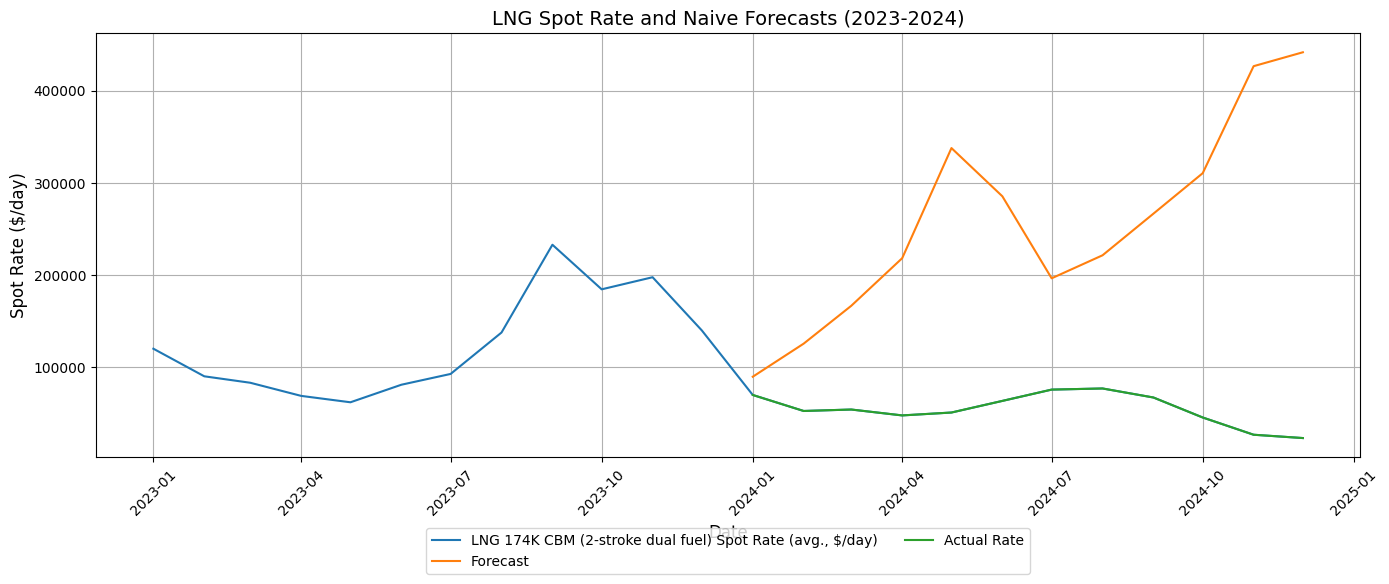

In [4]:
# 12 Month only rate and gas prices

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 51120.73, RMSE: 60245.26


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


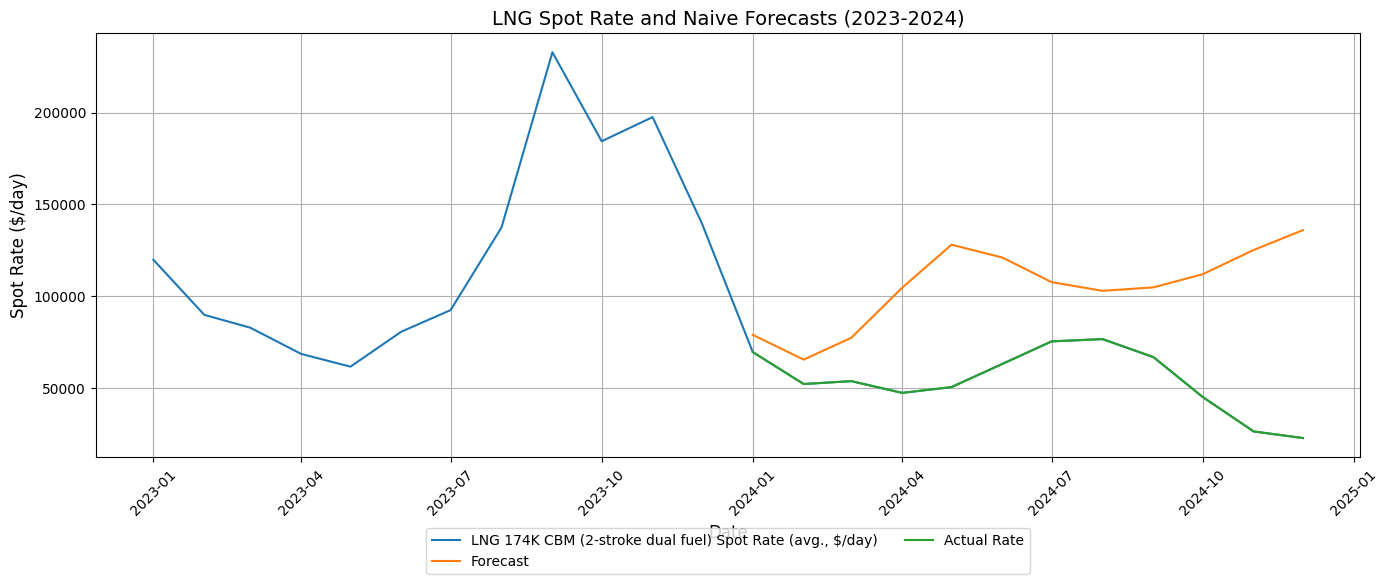

In [5]:
# 12 Month Gas price, spread and shipping capacity

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",LNG Shipping Capacity (CBM),"LNG Carrier Newbuilding Prices (end month, $m)","LNG Orderbook (start month, CBM)","Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,Forecast Jan - Jun,Forecast Feb - Jul,Forecast Mar - Aug,Forecast Apr - Sep,Forecast May - Oct,Forecast Jun - Nov,Forecast Jul - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,69843618,184.0,20754659,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,70711428,185.0,20634205,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,71241828,185.0,21336426,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,71939628,185.0,20995107,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,72450028,185.5,21169438,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,106147278,262.0,63005013,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,NaN,NaN,18905.931997,62776.130324,31489.893358,39804.573924,72734.725143,76800.0
2024-09-01,67000.000,106849278,261.5,62295413,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,NaN,NaN,NaN,59966.072995,33449.518121,42168.163474,74289.055351,67000.0
2024-10-01,45312.500,108597278,261.0,62921714,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,NaN,NaN,NaN,NaN,33084.108247,42392.978924,75305.977309,45312.5


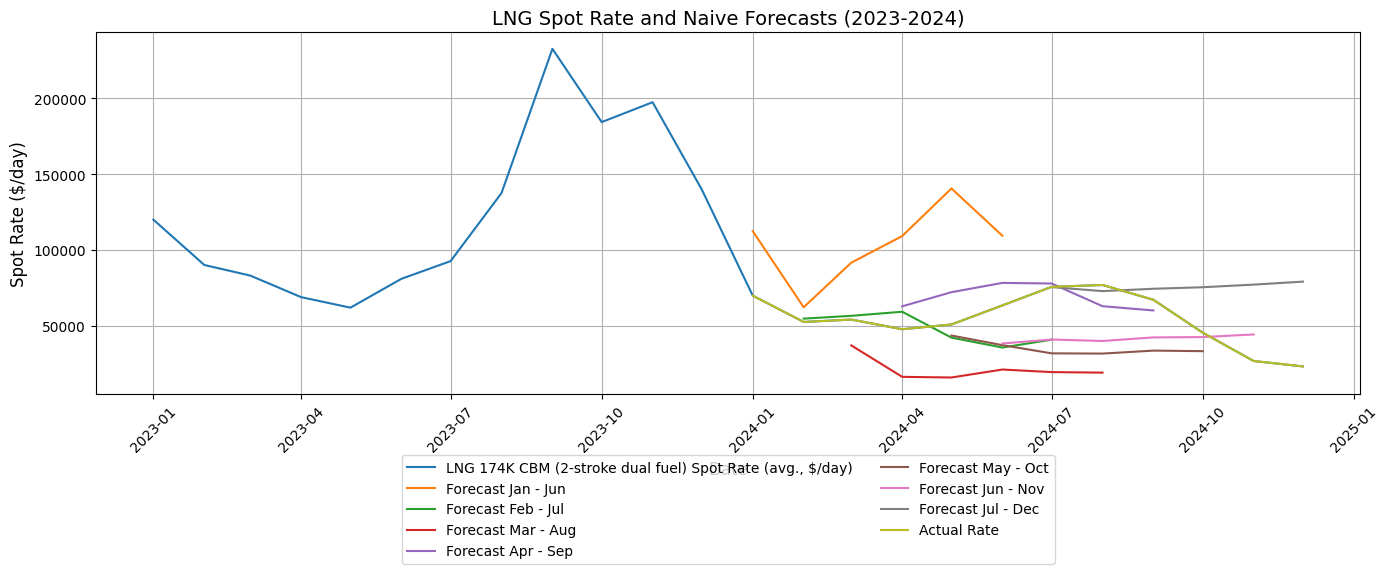

In [68]:
# 6 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-06-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    #print(forecast_steps)
    #print(forecast_range)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",LNG Shipping Capacity (CBM),"LNG Carrier Newbuilding Prices (end month, $m)","LNG Orderbook (start month, CBM)","Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,...,Forecast Feb - Apr,Forecast Mar - May,Forecast Apr - Jun,Forecast May - Jul,Forecast Jun - Aug,Forecast Jul - Sep,Forecast Aug - Oct,Forecast Sep - Nov,Forecast Oct - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,69843618,184.0,20754659,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,70711428,185.0,20634205,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,71241828,185.0,21336426,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,71939628,185.0,20995107,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,72450028,185.5,21169438,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,106147278,262.0,63005013,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,...,NaN,NaN,NaN,NaN,39804.573924,72734.725143,65517.715684,NaN,NaN,76800.0
2024-09-01,67000.000,106849278,261.5,62295413,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,...,NaN,NaN,NaN,NaN,NaN,74289.055351,71675.927255,94661.448705,NaN,67000.0
2024-10-01,45312.500,108597278,261.0,62921714,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,...,NaN,NaN,NaN,NaN,NaN,NaN,69387.072868,101595.907755,70796.116336,45312.5


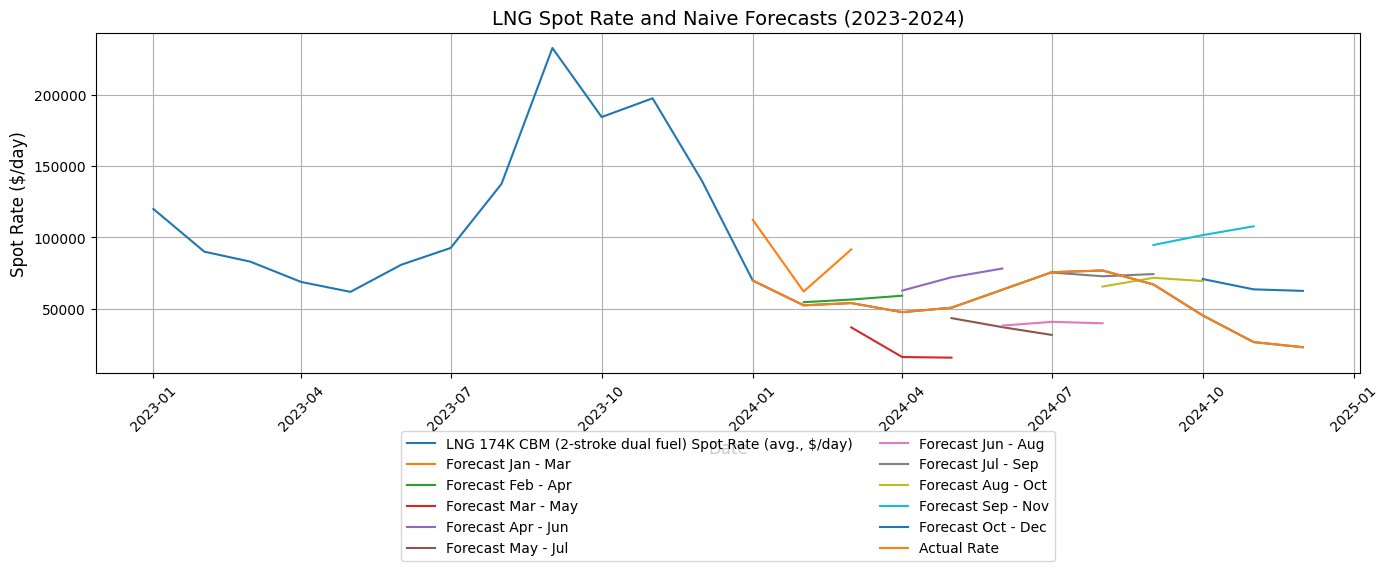

In [69]:
# 3 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)","Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,Forecast Jan - Mar,Forecast Feb - Apr,Forecast Mar - May,Forecast Apr - Jun,Forecast May - Jul,Forecast Jun - Aug,Forecast Jul - Sep,Forecast Aug - Oct,Forecast Sep - Nov,Forecast Oct - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,NaN,NaN,NaN,NaN,NaN,58520.160569,70090.655777,72375.956563,NaN,NaN,76800.0
2024-09-01,67000.000,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,NaN,NaN,NaN,NaN,NaN,NaN,72830.651215,75992.986544,88307.125933,NaN,67000.0
2024-10-01,45312.500,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78490.488453,97915.217253,64467.386664,45312.5


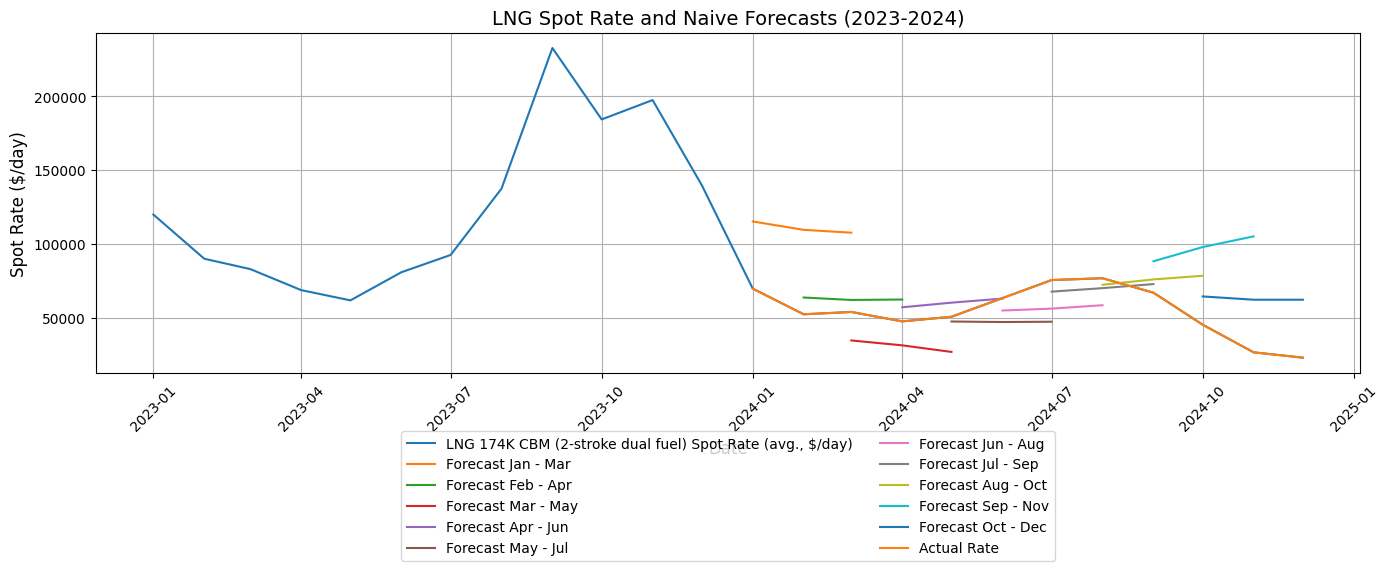

In [70]:
# 3 Month gas prices

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",LNG Shipping Capacity (CBM),Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,Forecast Jan - Mar,Forecast Feb - Apr,Forecast Mar - May,Forecast Apr - Jun,Forecast May - Jul,Forecast Jun - Aug,Forecast Jul - Sep,Forecast Aug - Oct,Forecast Sep - Nov,Forecast Oct - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,
2019-01-01,91358.125,69843618,4.052369,5.176957,1.124587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,70711428,3.306839,3.821500,0.514661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,71241828,2.393847,2.441905,0.048058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,71939628,2.355977,2.482489,0.126512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,72450028,1.768444,2.441522,0.673078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,106147278,10.098846,11.118000,1.019154,NaN,NaN,NaN,NaN,NaN,54325.826651,63745.524636,80260.222251,NaN,NaN,76800.0
2024-09-01,67000.000,106849278,9.349860,10.689048,1.339188,NaN,NaN,NaN,NaN,NaN,NaN,65033.907722,84805.890063,82966.754964,NaN,67000.0
2024-10-01,45312.500,108597278,10.180217,10.538217,0.358000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88220.363011,87070.672604,62628.830000,45312.5


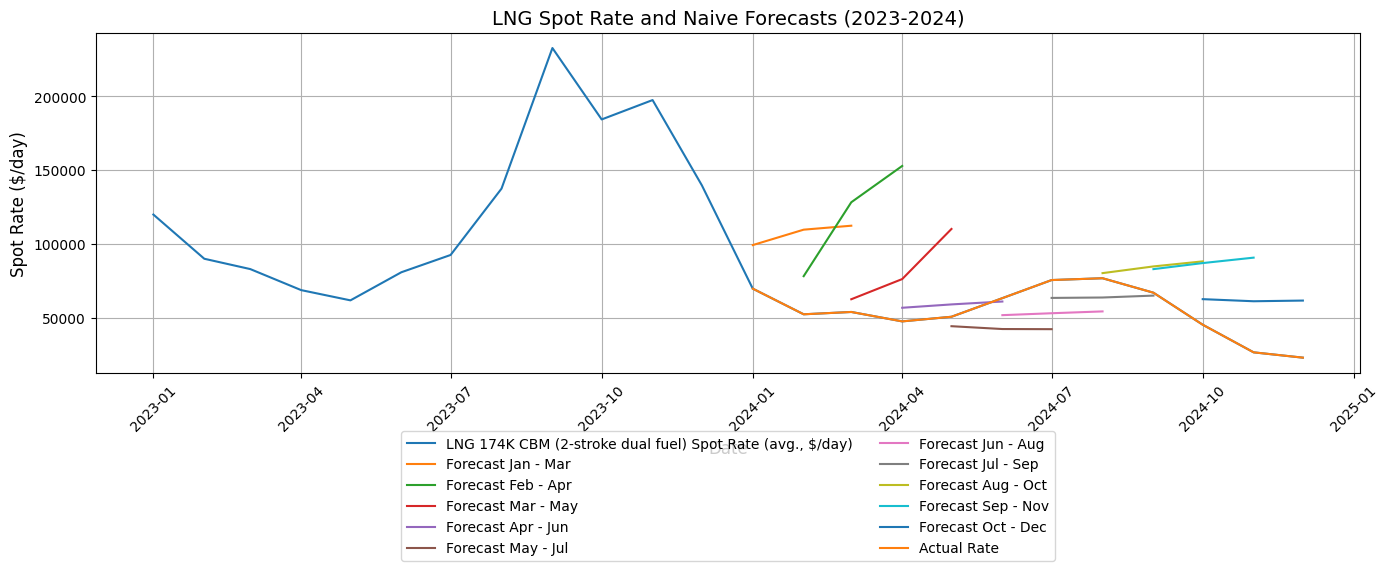

In [82]:
# 3 Month gas prices + tonnage

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=4).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00
2024-11-01 00:00:00
2024-12-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",LNG Shipping Capacity (CBM),"LNG Carrier Newbuilding Prices (end month, $m)","LNG Orderbook (start month, CBM)","Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,...,Forecast Apr - Apr,Forecast May - May,Forecast Jun - Jun,Forecast Jul - Jul,Forecast Aug - Aug,Forecast Sep - Sep,Forecast Oct - Oct,Forecast Nov - Nov,Forecast Dec - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,69843618,184.0,20754659,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,70711428,185.0,20634205,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,71241828,185.0,21336426,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,71939628,185.0,20995107,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,72450028,185.5,21169438,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,106147278,262.0,63005013,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,...,NaN,NaN,NaN,NaN,65517.715684,NaN,NaN,NaN,NaN,76800.0
2024-09-01,67000.000,106849278,261.5,62295413,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,...,NaN,NaN,NaN,NaN,NaN,94661.448705,NaN,NaN,NaN,67000.0
2024-10-01,45312.500,108597278,261.0,62921714,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,...,NaN,NaN,NaN,NaN,NaN,NaN,70796.116336,NaN,NaN,45312.5


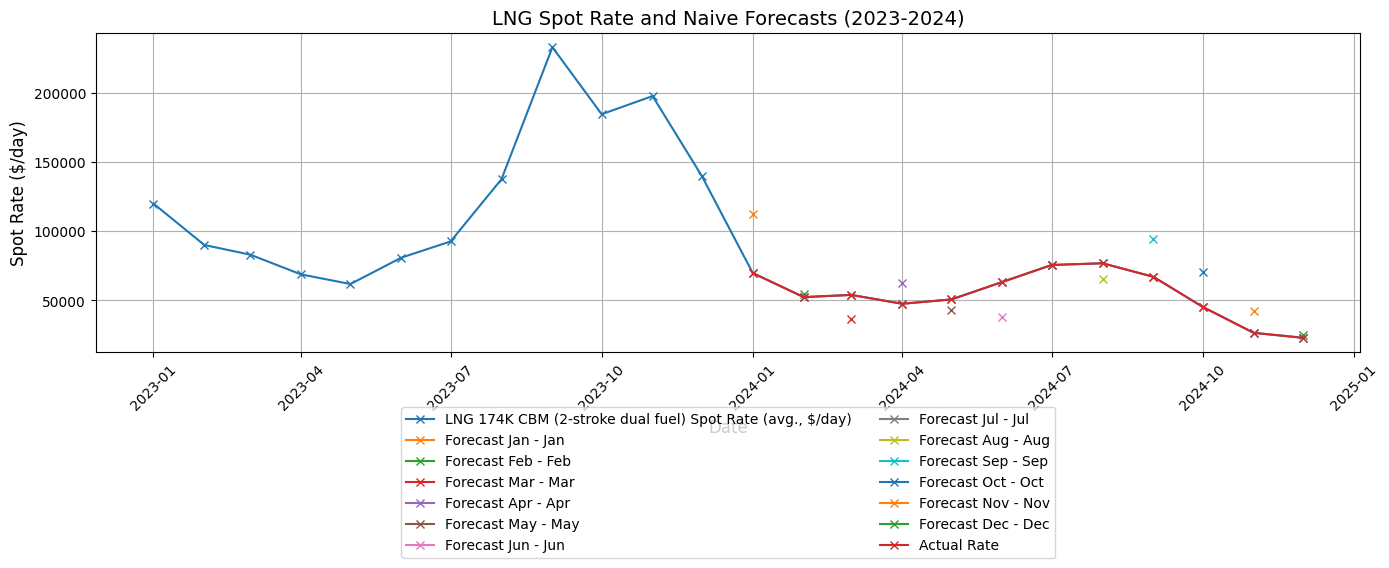

In [ ]:
# 1 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column, marker="x")

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00
2024-11-01 00:00:00
2024-12-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",LNG Shipping Capacity (CBM),"Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,Forecast Jan - Jan,Forecast Feb - Feb,...,Forecast Apr - Apr,Forecast May - May,Forecast Jun - Jun,Forecast Jul - Jul,Forecast Aug - Aug,Forecast Sep - Sep,Forecast Oct - Oct,Forecast Nov - Nov,Forecast Dec - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,69843618,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,70711428,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,71241828,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,71939628,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,72450028,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,106147278,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,NaN,NaN,...,NaN,NaN,NaN,NaN,73039.502235,NaN,NaN,NaN,NaN,76800.0
2024-09-01,67000.000,106849278,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,88238.89725,NaN,NaN,NaN,67000.0
2024-10-01,45312.500,108597278,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63404.732418,NaN,NaN,45312.5


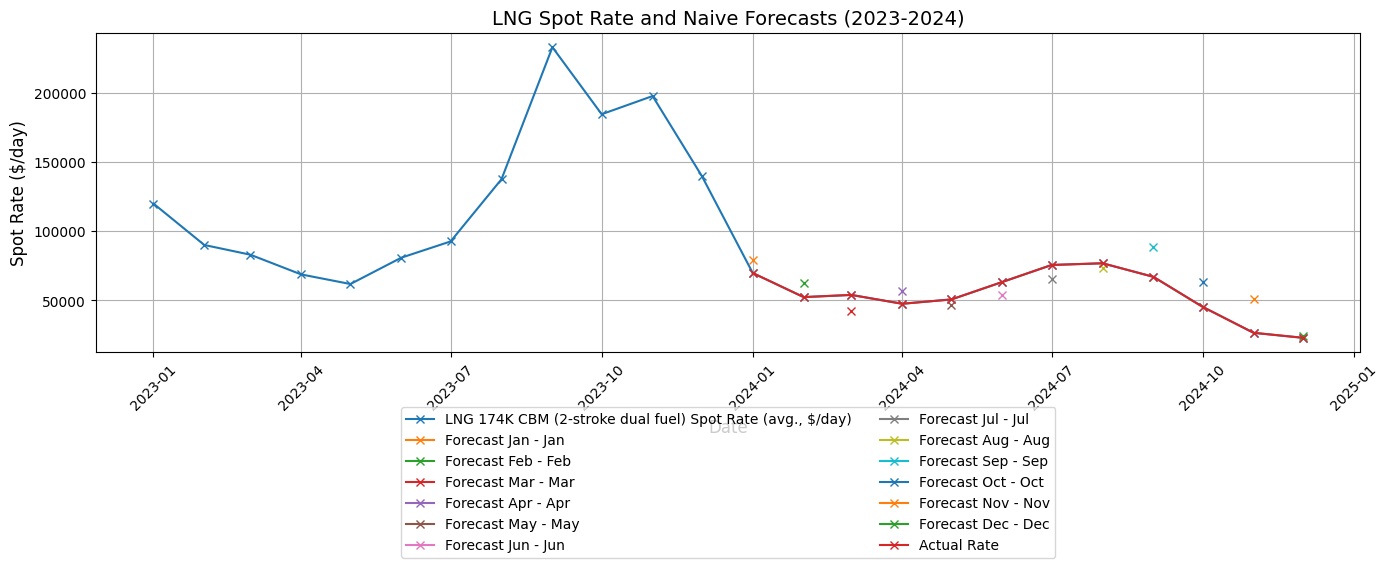

In [88]:
# 1 Month prices + tonnasje

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column, marker="x")

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00
2024-11-01 00:00:00
2024-12-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/F

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)","Global price of Natural Gas, Asia (start month, MMBTU)","Global price of Natural Gas, EU (start month, MMBTU)","Global price of Natural Gas, US Henry Hub (start month, MMBTU)",Spread\nEU-US,Spread\nASIA-US,Spread\nASIA-EU,Forecast Jan - Jan,Forecast Feb - Feb,Forecast Mar - Mar,Forecast Apr - Apr,Forecast May - May,Forecast Jun - Jun,Forecast Jul - Jul,Forecast Aug - Aug,Forecast Sep - Sep,Forecast Oct - Oct,Forecast Nov - Nov,Forecast Dec - Dec,Actual Rate
Date,,,,,,,,,,,,,,,,,,,,
2019-01-01,91358.125,8.285652,7.161065,3.108696,4.052369,5.176957,1.124587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,68721.750,6.501000,5.986339,2.679500,3.306839,3.821500,0.514661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,48349.900,5.245238,5.197180,2.803333,2.393847,2.441905,0.048058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,48500.000,5.079762,4.953250,2.597273,2.355977,2.482489,0.126512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,64600.000,5.033261,4.360183,2.591739,1.768444,2.441522,0.673078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,76800.000,13.213000,12.193846,2.095000,10.098846,11.118000,1.019154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72375.956563,NaN,NaN,NaN,NaN,76800.0
2024-09-01,67000.000,13.090000,11.750812,2.400952,9.349860,10.689048,1.339188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88307.125933,NaN,NaN,NaN,67000.0
2024-10-01,45312.500,13.113000,12.755000,2.574783,10.180217,10.538217,0.358000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64467.386664,NaN,NaN,45312.5


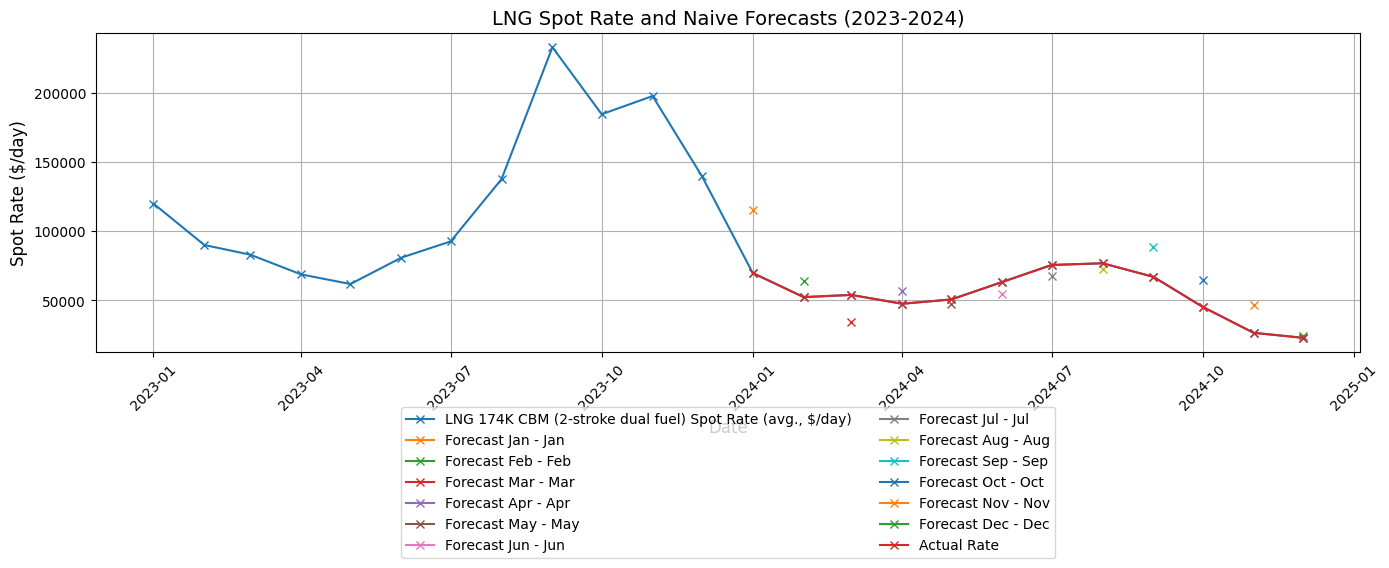

In [87]:
# 1 Month prices

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(forecast_start_date)
    mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
#display(df_train)

    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)

    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    df_forecast.loc[forecast_range, f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"] = recovered_forecast
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


#mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
#rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
#print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column, marker="x")

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
